<a href="https://colab.research.google.com/github/mrhamedani/Gen-AI-projects-Pytorch/blob/main/5_blonde_black_hair_CelebFaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Download and prepare the Dataset
The eyeglasses dataset we use is from Kaggle. Log into Kaggle and go to the link https://www.kaggle.com/datasets/jessicali9530/celeba-dataset to download the image folder and the two CSV files on the right

Using the Kaggle API JSON file, I saved the data set directly in the Google Colab temporary memory

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip celeba-dataset.zip

In [ ]:
import pandas as pd
import os, shutil
import random
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import albumentations
from albumentations.pytorch import ToTensorV2
import os
from torch.utils.data import Dataset
import numpy as np
import tqdm
from PIL import Image

In [84]:
df=pd.read_csv("./list_attr_celeba.csv")    #A
os.makedirs("./cyclegan/black", exist_ok=True)
os.makedirs("./cyclegan/blond", exist_ok=True)    #B
folder="./img_align_celeba/img_align_celeba"
for i in range(len(df)):
    dfi=df.iloc[i]
    if dfi['Black_Hair']==1:    #C
        try:
            oldpath=f"{folder}/{dfi['image_id']}"
            newpath=f"./cyclegan/black/{dfi['image_id']}"
            shutil.move(oldpath, newpath)
        except:
            pass
    elif dfi['Blond_Hair']==1:    #D
        try:
            oldpath=f"{folder}/{dfi['image_id']}"
            newpath=f"./cyclegan/blond/{dfi['image_id']}"
            shutil.move(oldpath, newpath)
        except:
            pass

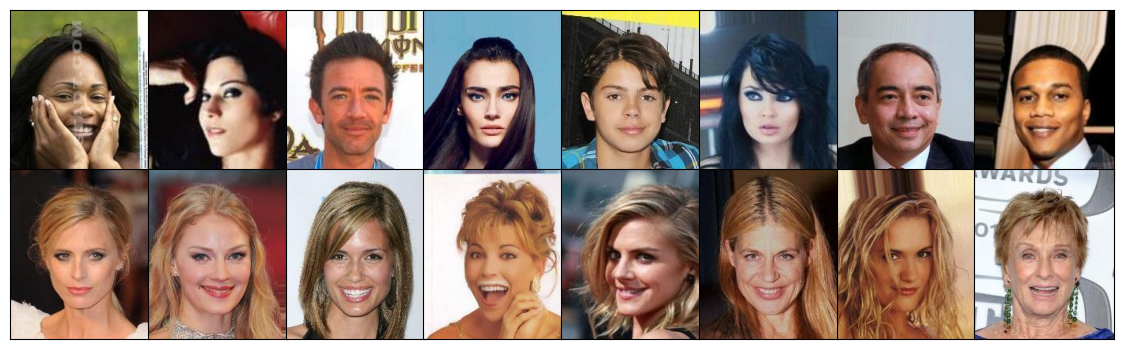

In [88]:
imgs=os.listdir(trainA)
random.seed(42)
samples=random.sample(imgs,8)
imgs1=os.listdir(trainB)
random.seed(42)
samples1=random.sample(imgs1,8)
fs=[trainA,trainB]
ps=[imgs,imgs1]
fig=plt.figure(dpi=100, figsize=(1.78*8,2.18*2))
for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    folder=i//8
    p=i%8
    img=Image.open(fr"{fs[folder]}{ps[folder][p]}")
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(wspace=-0.01,hspace=-0.1)
plt.show()

In [86]:
class LoadData(Dataset):
    def __init__(self, root_A, root_B, transform=None):
        super().__init__()
        self.root_A = root_A
        self.root_B = root_B
        self.transform = transform
        self.A_images = []
        self.B_images = []

        for r in root_A:
            files=os.listdir(r)
            self.A_images += [r+i for i in files]

        for r in root_B:
            files=os.listdir(r)
            self.B_images += [r+i for i in files]

        self.len_data = max(len(self.A_images), len(self.B_images))
        self.A_len = len(self.A_images)
        self.B_len = len(self.B_images)

    def __len__(self):
        return self.len_data

    def __getitem__(self, index):
        A_img = self.A_images[index % self.A_len]
        B_img = self.B_images[index % self.B_len]
        A_img = np.array(Image.open(A_img).convert("RGB"))
        B_img = np.array(Image.open(B_img).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=B_img, image0=A_img)
            B_img = augmentations["image"]
            A_img = augmentations["image0"] #S
 # transform takes only one input("image"), but we want to send two photos at the same time,
 # so we have to define in part S that there is a second photo("image0") as well.
        return A_img, B_img

In [87]:
transforms = albumentations.Compose([
                                    albumentations.Resize(width=256, height=256), albumentations.HorizontalFlip(p=0.5),
                                    albumentations.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255),
                                    ToTensorV2()], additional_targets={"image0": "image"})    #S
#"image0" --> A_img = augmentations["image0"] , "image" is format(There are other formats too)
dataset = LoadData(root_A=["./cyclegan/black/"], root_B=["./cyclegan/blond/"], transform=transforms)

loader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True)


#CycleGAN requires
 two generators and two discriminators, but here, we define one class for each (Generator and Discriminator) and then create two instances of each class.

In [89]:
class Block(nn.Module):
    def __init__(self,in_channels,out_channels,stride):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels,out_channels,4,stride,1,padding_mode="reflect"),
                                  nn.InstanceNorm2d(out_channels),
                                  nn.LeakyReLU(0.2,inplace=True))

    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64,128,256,512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels,features[0], kernel_size=4,stride=2,padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True))

        layers = []
        in_channels = features[0]

        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature == features[-1] else 2))
            in_channels = feature

        layers.append(nn.Conv2d(in_channels,1,kernel_size=4,stride=1,padding=1,padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        out = self.model(self.initial(x))
        return torch.sigmoid(out)

In [90]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def weights_init(m):
    name = m.__class__.__name__
    if name.find('Conv') != -1 or name.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif name.find('Norm2d') != -1:
        nn.init.constant_(m.weight.data, 1)
        nn.init.constant_(m.bias.data, 0)

disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)
weights_init(disc_A)
weights_init(disc_B)

In [91]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
            if down else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity())

    def forward(self, x):
        return self.conv(x)
# ResidualBlock: x + self.block(x)   for solv the problem of vanishing gradient
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels,channels,kernel_size=3,padding=1),
            ConvBlock(channels,channels,use_act=False, kernel_size=3, padding=1))

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels,num_features,kernel_size=7, stride=1,padding=3,padding_mode="reflect",),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True))

# down for compressing and up for expanding
        self.down_blocks = nn.ModuleList(
            [ConvBlock(num_features,num_features*2,kernel_size=3, stride=2, padding=1),
            ConvBlock(num_features*2,num_features*4,kernel_size=3, stride=2,padding=1)])

        self.res_blocks = nn.Sequential(*[ResidualBlock(num_features * 4) for _ in range(num_residuals)])

        self.up_blocks = nn.ModuleList(
            [ConvBlock(num_features * 4, num_features * 2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvBlock(num_features * 2, num_features * 1, down=False,kernel_size=3, stride=2, padding=1, output_padding=1)])

        self.last = nn.Conv2d(num_features * 1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

#AMP (Auto Mixed Precision)
is one of the numerical calculation optimization techniques used in PyTorch to increase the speed of deep model training.

In this method, some neural network operations are executed with 16-bit precision (FP16) and others with 32-bit precision (FP32).
This work increases both the processing speed and the accuracy of the model.

In [92]:
gen_A = Generator(img_channels=3, num_residuals=9).to(device)
gen_B = Generator(img_channels=3, num_residuals=9).to(device)
weights_init(gen_A)
weights_init(gen_B)

l1 = nn.L1Loss()
mse = nn.MSELoss()
g_scaler = torch.amp.GradScaler()
d_scaler = torch.amp.GradScaler()

/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [93]:
lr = 0.00001
opt_disc = torch.optim.Adam(list(disc_A.parameters()) + list(disc_B.parameters()),lr=lr,betas=(0.5, 0.999))
opt_gen = torch.optim.Adam(list(gen_A.parameters()) + list(gen_B.parameters()),lr=lr,betas=(0.5, 0.999))

In [94]:
def test(i,A,B,fake_A,fake_B): #directory files must be created before
    save_image(A*0.5+0.5,f"files/A{i}.png")
    save_image(B*0.5+0.5,f"files/B{i}.png")    #A
    save_image(fake_A*0.5+0.5,f"files/fakeA{i}.png")
    save_image(fake_B*0.5+0.5,f"files/fakeB{i}.png")    #B

In [95]:
def train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler,device):
    loop = tqdm(loader, leave=True)

    for i, (A,B) in enumerate(loop):
        A=A.to(device)
        B=B.to(device)

        # Train Discriminators A and B
        with torch.cuda.amp.autocast():
            fake_A = gen_A(B)
            D_A_real = disc_A(A)
            D_A_fake = disc_A(fake_A.detach())
            D_A_real_loss = mse(D_A_real, torch.ones_like(D_A_real))
            D_A_fake_loss = mse(D_A_fake, torch.zeros_like(D_A_fake))
            D_A_loss = D_A_real_loss + D_A_fake_loss

            fake_B = gen_B(A)
            D_B_real = disc_B(B)
            D_B_fake = disc_B(fake_B.detach())
            D_B_real_loss = mse(D_B_real, torch.ones_like(D_B_real))
            D_B_fake_loss = mse(D_B_fake, torch.zeros_like(D_B_fake))
            D_B_loss = D_B_real_loss + D_B_fake_loss

            # Average loss of the two discriminators
            D_loss = (D_A_loss + D_B_loss) / 2

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        # Train the two generators
        with torch.cuda.amp.autocast():
            D_A_fake = disc_A(fake_A)
            D_B_fake = disc_B(fake_B)
            loss_G_A = mse(D_A_fake, torch.ones_like(D_A_fake))
            loss_G_B = mse(D_B_fake, torch.ones_like(D_B_fake))
            # NEW in Cycle GANs: cycle loss
            cycle_B = gen_B(fake_A)
            cycle_A = gen_A(fake_B)
            cycle_B_loss = l1(B, cycle_B)
            cycle_A_loss = l1(A, cycle_A)
            # Total generator loss
            G_loss=(loss_G_A+loss_G_B+cycle_A_loss*10 +cycle_B_loss*10)
        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        if i % 100 == 0:
            test(i,A,B,fake_A,fake_B)
        loop.set_postfix(D_loss=D_loss.item(),G_loss=G_loss.item())

In [ ]:
# for epoch in range(1):
#     train_epoch(disc_A, disc_B, gen_A, gen_B, loader, opt_disc, opt_gen, l1, mse, d_scaler, g_scaler, device)
# torch.save(gen_A.state_dict(), "files/gen_black.pth")
# torch.save(gen_B.state_dict(), "files/gen_blond.pth")

# download link , The training model is ready
 https://gitlab.com/amirbig44/pytorch-gan-course/-/blob/main/hair.zip?ref_type=heads

In [96]:
from torchvision.utils import save_image

gen_A.load_state_dict(torch.load("./hair/gen_black.pth", weights_only=False, map_location=device))
gen_B.load_state_dict(torch.load("./hair/gen_blond.pth", weights_only=False, map_location=device))
i=1
# cycleGAN test
for black,blond in loader:
    fake_blond=gen_B(black.to(device))
    save_image(black*0.5+0.5,f"files/black{i}.png")
    save_image(fake_blond*0.5+0.5,f"files/fakeblond{i}.png")
    fake2black=gen_A(fake_blond)
    save_image(fake2black*0.5+0.5,f"files/fake2black{i}.png")
    fake_black=gen_A(blond.to(device))
    save_image(blond*0.5+0.5,f"files/blond{i}.png")
    save_image(fake_black*0.5+0.5,f"files/fakeblack{i}.png")
    fake2blond=gen_B(fake_black)
    save_image(fake2blond*0.5+0.5,f"files/fake2blond{i}.png")
    i=i+1
    if i>10:
        break